# Requirements

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns
import geoplot
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk
import tempun

In [2]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [3]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import dataset

In [4]:
EDHCS = s.read_file("SDAM_data/social_diversity/EDHCS_occupsorgs_2021-05-27.geojson", "gdf")
EDHCS.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,occups,occups_N,organizations,organizations_N,geometry
0,EDCS-71300269,"AE 2014, 01203",Achaia,Achaia,Mavrommati / Mavromati / Messini / Messene,"['Mavrommati', 'Mavromati', 'Messini', 'Messene']",96,,"['sigilla impressa', 'tituli fabricationis', '...",tituli fabricationis,...,59,22337.0,"[22.008029, 37.051363]",middle,0.153060,[],0,[],0,POINT (21.92418 37.17941)
1,EDCS-21200140,"CIL 03, 00079 = CIL 03, 14147,6 = IDakke 00028",Aegyptus,Aegyptus,Ad-Dakka / El-Dakka / Dakke / Pselqet / Pselki...,"['Ad-Dakka', 'El-Dakka', 'Dakke', 'Pselqet', '...",109,,"['milites', 'tituli fabricationis', 'tituli sa...","['tituli fabricationis', 'tituli sacri']",...,126,33806.0,"[32.933333, 24.083333]",big,0.902158,[],0,[],0,POINT (32.75000 23.20000)
2,EDCS-21200142,"CIL 03, 00081 = CIL 03, 13584 = IDakke 00064a",Aegyptus,Aegyptus,Ad-Dakka / El-Dakka / Dakke / Pselqet / Pselki...,"['Ad-Dakka', 'El-Dakka', 'Dakke', 'Pselqet', '...",109,,{},{},...,126,33806.0,"[32.933333, 24.083333]",big,0.902158,[],0,[],0,POINT (32.75000 23.20000)
3,EDCS-52100002,IDakke 00064,Aegyptus,Aegyptus,Ad-Dakka / El-Dakka / Dakke / Pselqet / Pselki...,"['Ad-Dakka', 'El-Dakka', 'Dakke', 'Pselqet', '...",109,,tituli possessionis,tituli possessionis,...,126,33806.0,"[32.933333, 24.083333]",big,0.902158,[],0,[],0,POINT (32.75000 23.20000)
4,EDCS-44500113,IDakke 00100,Aegyptus,Aegyptus,Ad-Dakka / El-Dakka / Dakke / Pselqet / Pselki...,"['Ad-Dakka', 'El-Dakka', 'Dakke', 'Pselqet', '...",117,,"['Augusti/Augustae', 'milites', 'ordo equester...",tituli sacri,...,126,33806.0,"[32.933333, 24.083333]",big,0.902158,[],0,[],0,POINT (32.75000 23.20000)


# Occupations by cities

In [7]:
print(list(EDHCS.columns))

['EDCS-ID', 'publication', 'province', 'province_list', 'place', 'place_list', 'end_yr_list', 'notes_dating', 'status_list', 'inscr_type', 'status_notation', 'inscr_process', 'notes_references', 'notes_comments', 'inscription', 'inscription_stripped_final', 'Links', 'dating from', 'dating to', 'status', 'Latitude', 'Longitude', 'photo', 'Material', 'Comment', 'EDH-ID', 'language_EDCS', 'clean_text_interpretive_word_EDCS', 'responsible_individual', 'type_of_inscription', 'letter_size', 'literature', 'work_status', 'height', 'diplomatic_text', 'people', 'depth', 'material', 'type_of_monument', 'province_label', 'width', 'transcription', 'country', 'uri', 'findspot_ancient', 'last_update', 'modern_region', 'findspot_modern', 'edh_geography_uri', 'commentary', 'trismegistos_uri', 'external_image_uris', 'fotos', 'idno_tm', 'placenames_refs', 'text_edition', 'origdate_text', 'layout_execution', 'layout_execution_text', 'support_objecttype', 'support_objecttype_text', 'support_material', 'sup

In [32]:
len(EDHCS[EDHCS["occups_N"] > 0])

3293

In [71]:
occups_cities = dict(EDHCS[EDHCS["occups_N"] > 0].groupby("nearest_city")["occups_N"].sum())

In [72]:
len(occups_cities)

457

In [106]:
cities_pop = gpd.read_file("../data/roman_cities_pop.geojson", driver="GeoJSON")
cities_pop

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,Estimate Basis,num_of_structures,ID,level_0,Unnamed: 0_y,index,pop_sample,pop_est,pop_diff,geometry
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,Walls,5,1,NaN,NaN,NaN,NaN,1700.0,NaN,POINT (22.93333 38.58333)
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,None,3,2,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (23.73409 38.08347)
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,None,7,3,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (23.21970 38.45261)
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,...,Inhabited area,8,4,NaN,NaN,NaN,NaN,8209.0,NaN,POINT (23.42850 37.75007)
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,...,None,8,5,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (22.35572 38.14795)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,Hanson2016_1384,Pautalia,Kyustendi,Thracia,Bulgaria,3,49 E1,98,NaN,BNP; DGRG; Jones 1937; PECS; Wilkes 2003b.,...,None,11,1384,NaN,NaN,NaN,NaN,1000.0,NaN,POINT (22.68075 42.28252)
1384,Hanson2016_1385,Philippopolis (Thracia),Plovdiv,Thracia,Bulgaria,2,22 B6,-342,NaN,BNP; Cohen 1995; DGRG; Hansen and Nielsen 2004...,...,Walls,12,1385,NaN,NaN,NaN,NaN,14111.0,NaN,POINT (24.75091 42.14665)
1385,Hanson2016_1386,Samothrace,Samothrace,Thracia,Greece,3,51 F3,-700,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,Walls,6,1386,NaN,NaN,NaN,NaN,3252.0,NaN,POINT (25.52925 40.50069)
1386,Hanson2016_1387,Serdica,Sophia,Thracia,Bulgaria,2,21 F7,45,NaN,BNP; DGRG; Jones 1937; PECS; Sear 2006; Wilkes...,...,Inhabited area,9,1387,NaN,NaN,NaN,NaN,15580.0,NaN,POINT (23.34289 42.72283)


In [121]:
cities_occups_pops = pd.DataFrame([{"city" : key, "occups_N" : value, "city_pop" : cities_pop[cities_pop["Ancient Toponym"]==key]["pop_est"].tolist()[0], "Country" : cities_pop[cities_pop["Ancient Toponym"]==key]["Country"].tolist()[0]} for (key,value) in occups_cities.items() if value > 5])
len(cities_occups_pops)

135

In [122]:
cities_occups_pops = cities_occups_pops[cities_occups_pops["Country"]=="Italy"]

In [123]:
len(cities_occups_pops)

75

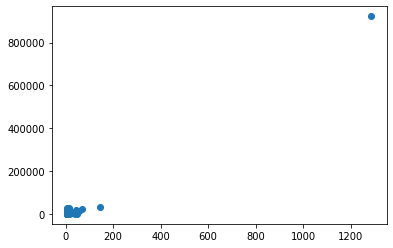

In [118]:
plt.scatter(cities_occups_pops["occups_N"],  cities_occups_pops["city_pop"])

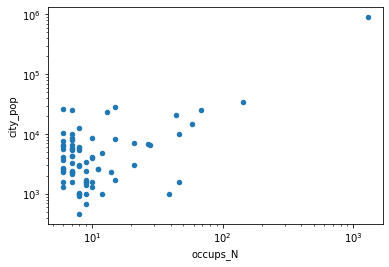

In [135]:
fig, ax = plt.subplots()
cities_occups_pops.plot.scatter("occups_N", "city_pop", ax=ax)
#x = np.log10(cities_occups_pops["occups_N"])
#y = np.log10(cities_occups_pops["city_pop"])
#m, b = np.polyfit(x, y, 1)
#plt.plot(x, m*x + b)

ax.set_yscale('log')
ax.set_xscale('log')

In [136]:
np.log2(cities_occups_pops["occups_N"]).corr(np.log2(cities_occups_pops["city_pop"]))

0.5516669090435693